In [8]:
!pip install -q catboost pandas scikit-learn joblib shap optuna wandb seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 20.5 MB/s eta 0:00:00


# Модель : прогноз цен float-sensitive оружия CS2

В этом разделе строится модель для датасета `float_sensitive_weapons.csv`:

- выполняется EDA и описывается структура данных;
- проводится очистка, кодирование и разбиение на train/val/test;
- обучаются несколько моделей (CatBoost baseline, CatBoost с HPO, Linear Regression);
- выполняется анализ важности признаков и SHAP-объяснения;
- оптимизируется время инференса с помощью Fast CatBoost;
- все эксперименты логируются в W&B.


In [9]:
import math
import time

import pandas as pd
import numpy as np

import joblib
import shap
import optuna
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

RANDOM_STATE = 42

DATA_PATH = "float_sensitive_weapons.csv"
TARGET_COL = "price"

NUM_FEATURES = [
    "float", "stattrak",
    "stickers_count", "stickers_total_value", "stickers_avg_value", "stickers_max_value",
    "slot0_price", "slot1_price", "slot2_price", "slot3_price",
]

CAT_FEATURES = ["weapon", "skin", "wear"]
ALL_FEATURES = NUM_FEATURES + CAT_FEATURES


#EDA

Размер датасета: (7663, 22)


,weapon,skin,wear,float,pattern,stattrak,price,phase,stickers_count,stickers_total_value,...,stickers_total_over_price,slot0_name,slot0_price,slot1_name,slot1_price,slot2_name,slot2_price,slot3_name,slot3_price,market_hash_name
0,AK-47,Ice Coaled,Factory New,0.052560,235,0,19.51,NaN,4,9.88,...,0.506407,Sticker | Natus Vincere (Gold) | Paris 2023,2.47,Sticker | Natus Vincere (Gold) | Paris 2023,2.47,Sticker | Natus Vincere (Gold) | Paris 2023,2.47,Sticker | Natus Vincere (Gold) | Paris 2023,2.47,AK-47 | Ice Coaled (Factory New)
1,AK-47,Ice Coaled,Factory New,0.051536,1,0,47.00,NaN,5,75.44,...,1.605106,Sticker | Cloud9 (Holo) | Copenhagen 2024,18.58,Sticker | Watermelon Tier6 (Holo),12.76,Sticker | Cloud9 (Holo) | Copenhagen 2024,18.58,Sticker | Watermelon Tier6 (Holo),12.76,AK-47 | Ice Coaled (Factory New)
2,AK-47,Ice Coaled,Factory New,0.063630,694,0,19.26,NaN,1,0.02,...,0.001038,Sticker | sjuush | Rio 2022,0.02,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Ice Coaled (Factory New)
3,AK-47,Ice Coaled,Factory New,0.000066,170,0,178.33,NaN,5,101.43,...,0.568777,Sticker | Cloud9 (Holo) | London 2018,25.24,Sticker | Cloud9 (Holo) | London 2018,25.24,Sticker | Cloud9 (Holo) | London 2018,25.24,Sticker | Cloud9 (Holo) | London 2018,25.24,AK-47 | Ice Coaled (Factory New)
4,AK-47,Ice Coaled,Factory New,0.067887,743,0,16.99,NaN,0,0.00,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AK-47 | Ice Coaled (Factory New)



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7663 entries, 0 to 7662
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   weapon                     7663 non-null   object 
 1   skin                       7663 non-null   object 
 2   wear                       7663 non-null   object 
 3   float                      7663 non-null   float64
 4   pattern                    7663 non-null   int64  
 5   stattrak                   7663 non-null   int64  
 6   price                      7663 non-null   float64
 7   phase                      0 non-null      float64
 8   stickers_count             7663 non-null   int64  
 9   stickers_total_value       7663 non-null   float64
 10  stickers_avg_value         7663 non-null   float64
 11  stickers_max_value         7663 non-null   float64
 12  stickers_total_over_price  7663 non-null   float64
 13  slot0_name          

,float,stattrak,stickers_count,stickers_total_value,stickers_avg_value,stickers_max_value,slot0_price,slot1_price,slot2_price,slot3_price,price
count,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000,7663.000000
mean,0.289610,0.192614,3.010701,2196.414948,790.515841,1633.147565,595.997077,403.145072,399.567514,725.884930,443.783957
std,0.188599,0.394378,1.768777,14671.345913,5932.042071,10874.562551,5890.611751,5054.938313,5045.082644,7081.660868,2239.175065
min,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.280000
25%,0.165484,0.000000,1.000000,0.645000,0.240000,0.310000,0.100000,0.000000,0.000000,0.000000,50.000000
50%,0.257532,0.000000,4.000000,30.360000,8.060000,12.020000,5.000000,3.630000,2.810000,1.320000,130.000000
75%,0.353627,0.000000,4.000000,321.970000,88.482000,138.400000,50.945000,38.680000,32.540000,28.710000,348.125000
max,0.999958,1.000000,5.000000,427861.110000,141149.230000,141149.230000,141149.230000,141149.230000,141149.230000,141149.230000,100000.000000



Количество пропусков:


,0
phase,7663
slot3_name,2931
slot2_name,2447
slot1_name,2063
slot0_name,1378
weapon,0
stattrak,0
pattern,0
float,0
wear,0


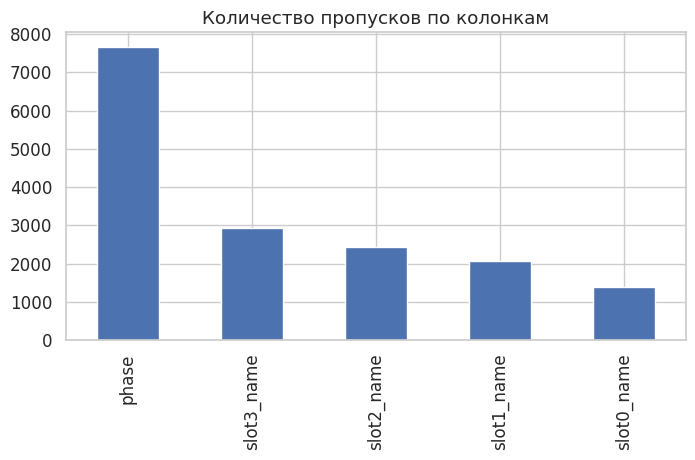

In [10]:
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

print("Размер датасета:", df.shape)
display(df.head())

print("\nИнформация о типах данных:")
df.info()

print("\nСтатистика по числовым колонкам:")
display(df[NUM_FEATURES + [TARGET_COL]].describe())

missing = df.isnull().sum().sort_values(ascending=False)
print("\nКоличество пропусков:")
display(missing)

plt.figure(figsize=(8, 4))
missing[missing > 0].plot(kind="bar")
plt.title("Количество пропусков по колонкам")
plt.show()


Общая структура датасета

* Размер: `7663` строк и `22` колонок (конкретные значения отображаются в выводе).
* Основные группы признаков:
  - числовые: `float`, `stattrak`, агрегаты по стикерам и цены в слотах;
  - категориальные: тип оружия (`weapon`), скин (`skin`), степень износа (`wear`);
  - таргет: `price` — рыночная цена оружия в долларах.

Диаграмма пропусков показывает, что в числовых и категориальных колонках встречаются
единичные пропуски, поэтому на этапе препроцессинга они заполняются
(0.0 для чисел и "unknown" для категорий).


## Распределение цены

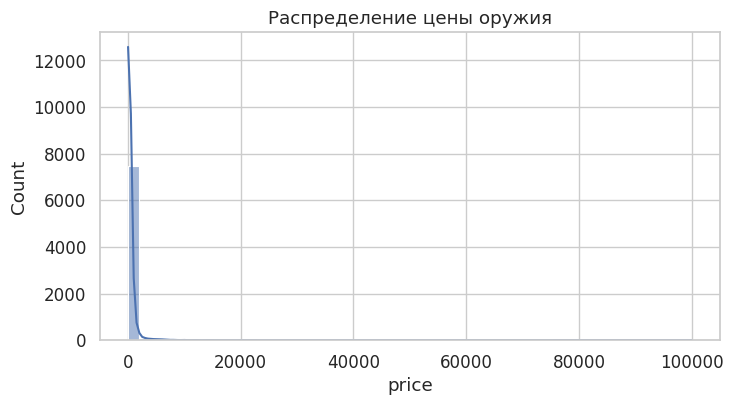

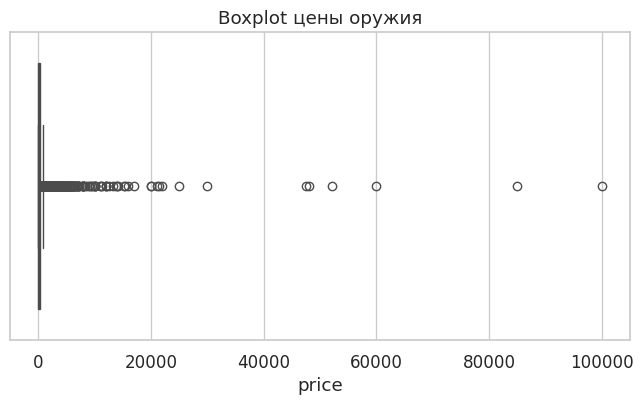

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET_COL], bins=50, kde=True)
plt.title("Распределение цены оружия")
plt.xlabel("price")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df[TARGET_COL])
plt.title("Boxplot цены оружия")
plt.show()


### Анализ распределения цены

*Гистограмма и boxplot* показывают правостороннее распределение:
большинство сделок лежит в диапазоне от дешёвых до средних цен, но присутствуют
редкие дорогие экземпляры. Это объясняет использование метрик MAE/RMSE
и чувствительность модели к выбросам

## weapon / wear

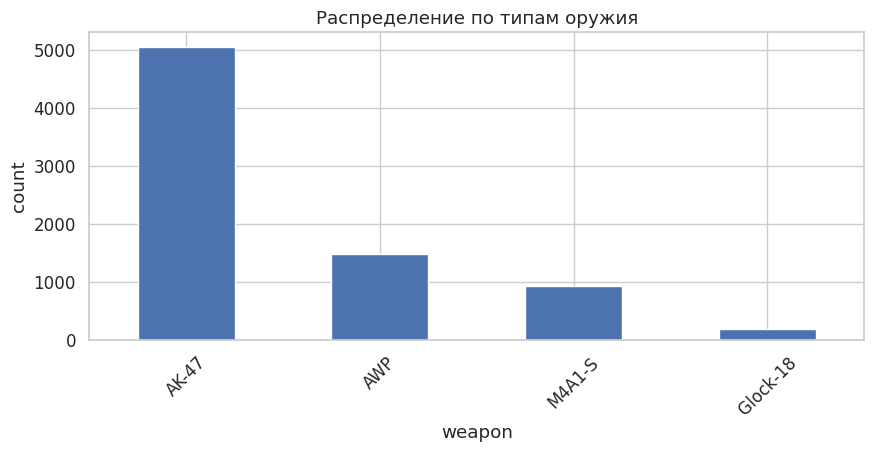

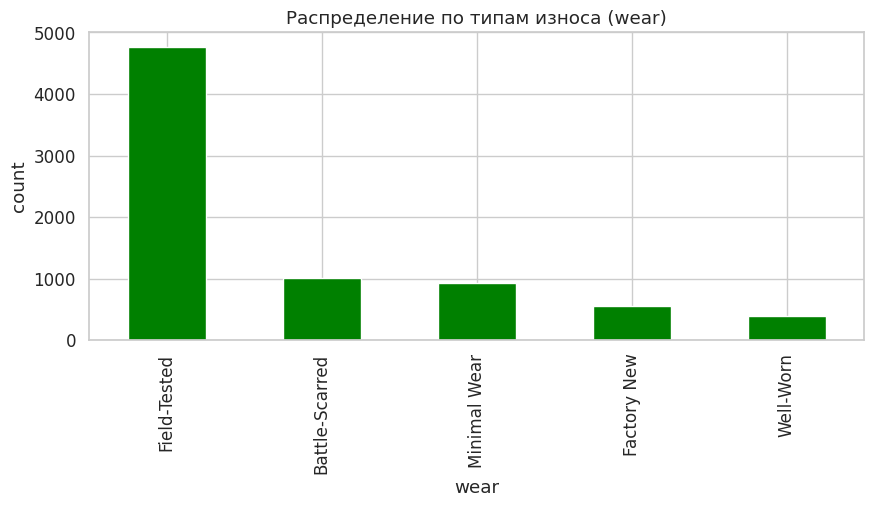

In [13]:
plt.figure(figsize=(10, 4))
df["weapon"].value_counts().plot(kind="bar")
plt.title("Распределение по типам оружия")
plt.xlabel("weapon")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
df["wear"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение по типам износа (wear)")
plt.xlabel("wear")
plt.ylabel("count")
plt.show()

### Категориальные признаки (weapon, wear)

Барплоты по `weapon` и `wear` показывают, какие типы оружия и уровни износа
представлены чаще всего. Это важно, так как модель обучается лучше на частых
классах, а качество предсказания для редких типов оружия может быть ниже.

## float

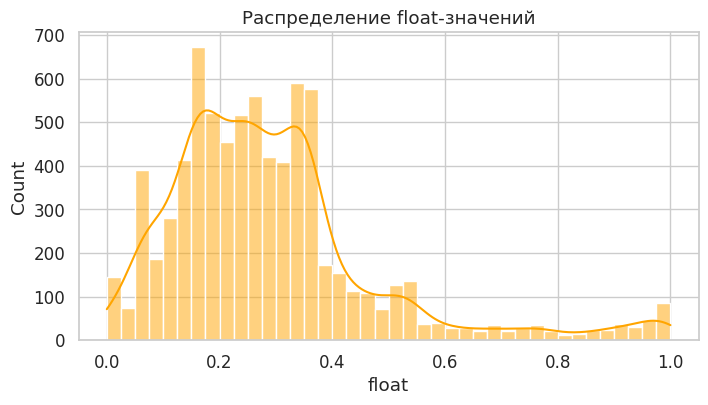

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(df["float"], bins=40, kde=True, color="orange")
plt.title("Распределение float-значений")
plt.xlabel("float")
plt.show()

### Распределение float

Гистограмма `float` показывает концентрацию значений в нижней части диапазона
(малый износ). Это логично для ликвидного оружия — предметы с высоким износом
менее востребованы.


## Корреляции

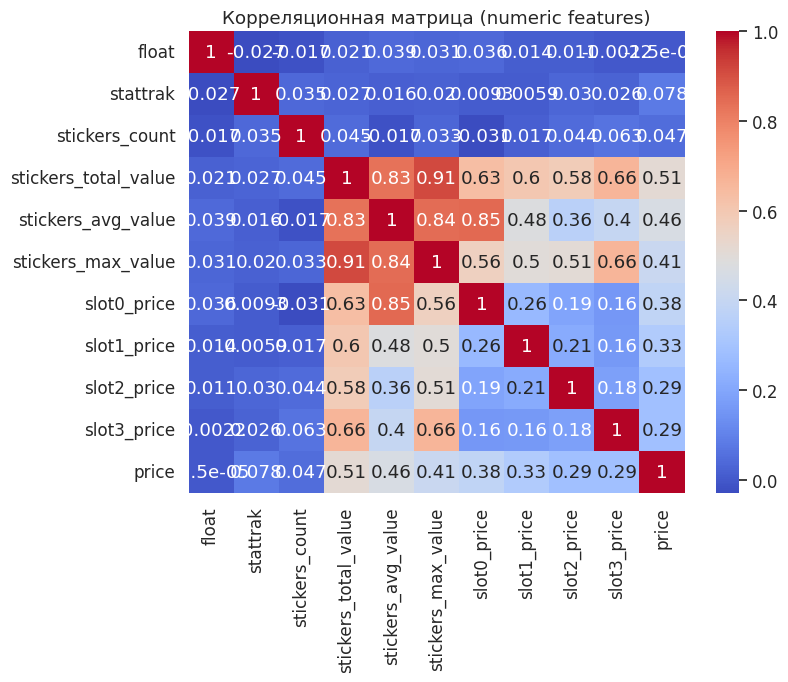

In [15]:
numeric_cols = NUM_FEATURES + [TARGET_COL]
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица (numeric features)")
plt.show()


### Корреляционная матрица

Тепловая карта по числовым признакам показывает:

- умеренную отрицательную корреляцию `float` ↔ `price` (чем выше износ, тем ниже цена),
- положительное влияние агрегатов по стикерам и цен по слотам,
- `stattrak` коррелирует с ценой слабее, но всё равно влияет.

Низкая линейная корреляция и сложные зависимости подтверждают выбор CatBoost,
который хорошо работает с нелинейностями.

##  float -> price

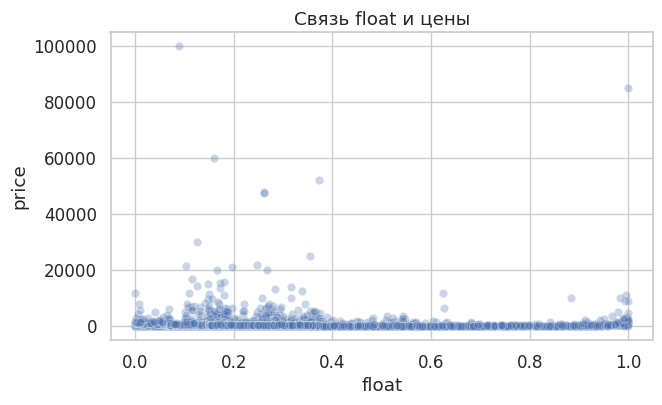

In [17]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x="float", y=TARGET_COL, data=df, alpha=0.3)
plt.title("Связь float и цены")
plt.xlabel("float")
plt.ylabel("price")
plt.show()


### Зависимость float → price

Scatterplot демонстрирует общий нисходящий тренд:
при увеличении `float` цена уменьшается, но разброс остаётся большим.
Это ещё один аргумент в пользу бустинга, а не простой линейной регрессии.

 ## StatTrak

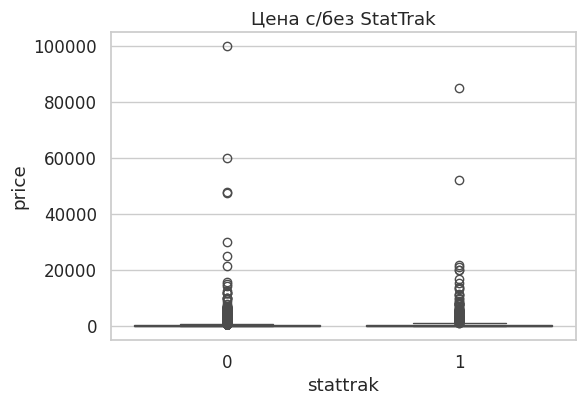

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="stattrak", y=TARGET_COL, data=df)
plt.title("Цена с/без StatTrak")
plt.xlabel("stattrak")
plt.ylabel("price")
plt.show()

### Влияние StatTrak

Boxplot по `stattrak` показывает, что медиана цены с `stattrak = 1`
стабильно выше, чем без него. Значит, бинарная фича `stattrak`
действительно добавляет полезную информацию.


## Средняя цена по weapon

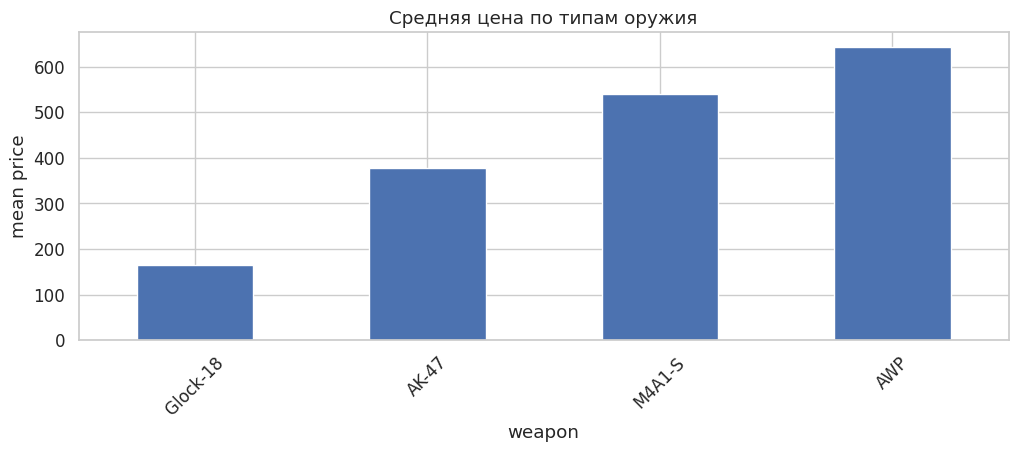

In [19]:
weapon_mean = df.groupby("weapon")[TARGET_COL].mean().sort_values()
plt.figure(figsize=(12, 4))
weapon_mean.plot(kind="bar")
plt.title("Средняя цена по типам оружия")
plt.xlabel("weapon")
plt.ylabel("mean price")
plt.xticks(rotation=45)
plt.show()

### Средняя цена по типам оружия

Барплот средних цен по `weapon` показывает, какие виды оружия
являются премиальными (AWP, редкие штурмовые винтовки)
и какие находятся в бюджетном сегменте.
Это подтверждает, что `weapon` — один из ключевых категориальных признаков.

#ML

Препроцессинг + train/val/test

In [20]:
# очистка по таргету
df = df[df[TARGET_COL].notna() & (df[TARGET_COL] > 0)].copy()

# числовые фичи
for col in NUM_FEATURES:
    if col not in df.columns:
        df[col] = 0.0
df[NUM_FEATURES] = df[NUM_FEATURES].fillna(0.0)

# категориальные фичи
for col in CAT_FEATURES:
    if col not in df.columns:
        df[col] = "unknown"
    df[col] = df[col].fillna("unknown").astype(str)

X = df[ALL_FEATURES]
y = df[TARGET_COL].astype(float)

print("Финальный набор признаков:", list(X.columns))
print("Размер после очистки:", X.shape)

# 70/15/15 сплит
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1765,
    random_state=RANDOM_STATE, shuffle=True
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

cat_indices = [X.columns.get_loc(c) for c in CAT_FEATURES]
train_pool = Pool(X_train, y_train, cat_features=cat_indices)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_indices)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_indices)


Финальный набор признаков: ['float', 'stattrak', 'stickers_count', 'stickers_total_value', 'stickers_avg_value', 'stickers_max_value', 'slot0_price', 'slot1_price', 'slot2_price', 'slot3_price', 'weapon', 'skin', 'wear']
Размер после очистки: (7663, 13)
Train: 5363, Val: 1150, Test: 1150


Для оценки обобщающей способности модели данные делятся на три части:
- train (70%) — обучение,
- validation (15%) — подбор гиперпараметров и ранняя остановка,
- test (15%) — финальная независимая оценка качества.


##Baseline CatBoost

In [21]:
baseline_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=120,
    verbose=False,
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_base = baseline_model.predict(test_pool)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = math.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("\n=== Baseline CatBoost (weapons) ===")
print(f"MAE:  {mae_base:.2f} $")
print(f"RMSE: {rmse_base:.2f} $")
print(f"R²:   {r2_base:.4f}")



=== Baseline CatBoost (weapons) ===
MAE:  192.94 $
RMSE: 739.91 $
R²:   0.6783


##Optuna HPO + tuned CatBoost

In [22]:
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 400, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": RANDOM_STATE,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": False,
    }
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    y_pred_val = model.predict(val_pool)
    rmse_val = math.sqrt(mean_squared_error(y_val, y_pred_val))
    return rmse_val

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\n=== Optuna Results (weapons) ===")
print("Best params:", study.best_params)
print("Best RMSE (val):", study.best_value)

best_params = study.best_params
best_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

tuned_model = CatBoostRegressor(**best_params)
tuned_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_tuned = tuned_model.predict(test_pool)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = math.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n=== Tuned CatBoost (Optuna, weapons) ===")
print(f"MAE:  {mae_tuned:.2f} $")
print(f"RMSE: {rmse_tuned:.2f} $")
print(f"R²:   {r2_tuned:.4f}")


[I 2025-12-03 00:06:24,662] A new study created in memory with name: no-name-5debac6b-274b-43ff-8159-80fb152348a3
[I 2025-12-03 00:06:25,898] Trial 0 finished with value: 515.5362888995884 and parameters: {'depth': 5, 'learning_rate': 0.012818845836188867, 'iterations': 1284, 'l2_leaf_reg': 0.07923320776919449}. Best is trial 0 with value: 515.5362888995884.
[I 2025-12-03 00:06:38,031] Trial 1 finished with value: 423.8116160895022 and parameters: {'depth': 10, 'learning_rate': 0.010886405838131932, 'iterations': 883, 'l2_leaf_reg': 0.8489076694444462}. Best is trial 1 with value: 423.8116160895022.
[I 2025-12-03 00:06:40,567] Trial 2 finished with value: 438.46043989095773 and parameters: {'depth': 7, 'learning_rate': 0.0195712729722342, 'iterations': 1462, 'l2_leaf_reg': 0.9472626957292363}. Best is trial 1 with value: 423.8116160895022.
[I 2025-12-03 00:06:49,121] Trial 3 finished with value: 400.4930559357651 and parameters: {'depth': 8, 'learning_rate': 0.03645035124438374, 'itera


=== Optuna Results (weapons) ===
Best params: {'depth': 10, 'learning_rate': 0.10864448798654708, 'iterations': 881, 'l2_leaf_reg': 4.63075763037707}
Best RMSE (val): 386.22689772567463

=== Tuned CatBoost (Optuna, weapons) ===
MAE:  197.94 $
RMSE: 789.79 $
R²:   0.6335


## Linear Regression baseline

In [23]:
numeric_features = NUM_FEATURES
categorical_features = CAT_FEATURES

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)
y_pred_lr = linreg_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n=== Linear Regression + OHE (weapons) ===")
print(f"MAE:  {mae_lr:.2f} $")
print(f"RMSE: {rmse_lr:.2f} $")
print(f"R²:   {r2_lr:.4f}")



=== Linear Regression + OHE (weapons) ===
MAE:  301.63 $
RMSE: 1178.02 $
R²:   0.1845


##Сравнение моделей

In [24]:
results_df = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr},
])

print("\n=== Сравнение моделей (weapons) ===")
display(results_df)



=== Сравнение моделей (weapons) ===


,model,MAE,RMSE,R2
0,CatBoost Baseline,192.942105,739.911698,0.678288
1,CatBoost Tuned,197.936355,789.787285,0.633455
2,Linear Regression,301.633192,1178.018660,0.184523


##Learning curves, feature importance, SHAP

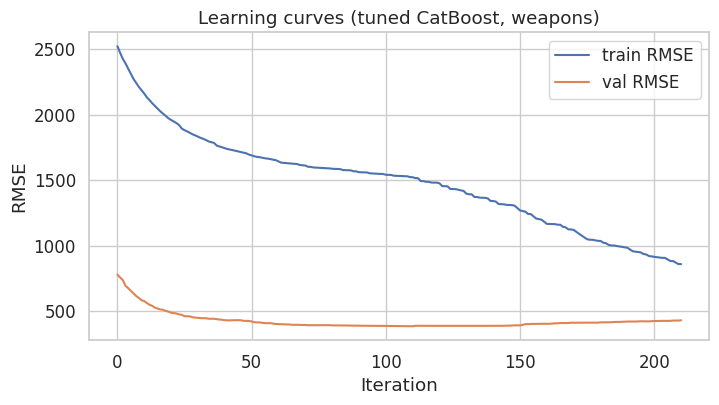


=== ТОП признаков (tuned CatBoost, weapons) ===


,feature,importance
1,stattrak,20.788717
4,stickers_avg_value,17.329641
0,float,13.262311
9,slot3_price,11.776191
3,stickers_total_value,6.771617
6,slot0_price,6.631353
8,slot2_price,4.836253
12,wear,4.723001
5,stickers_max_value,4.067485
11,skin,3.979185


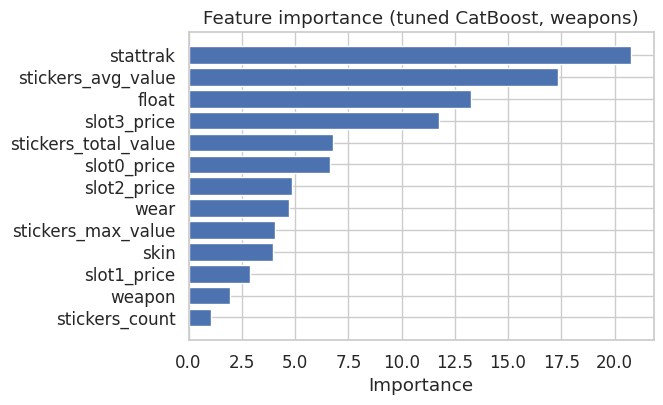

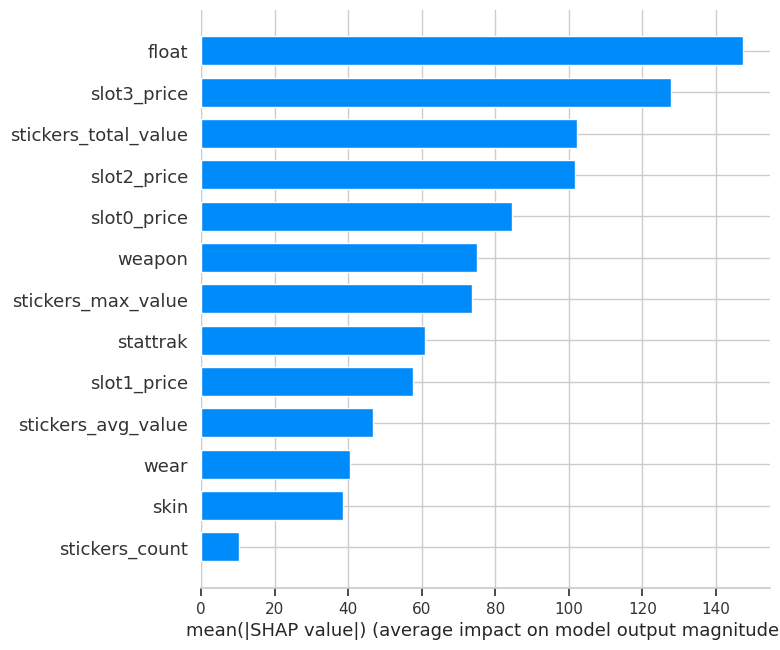

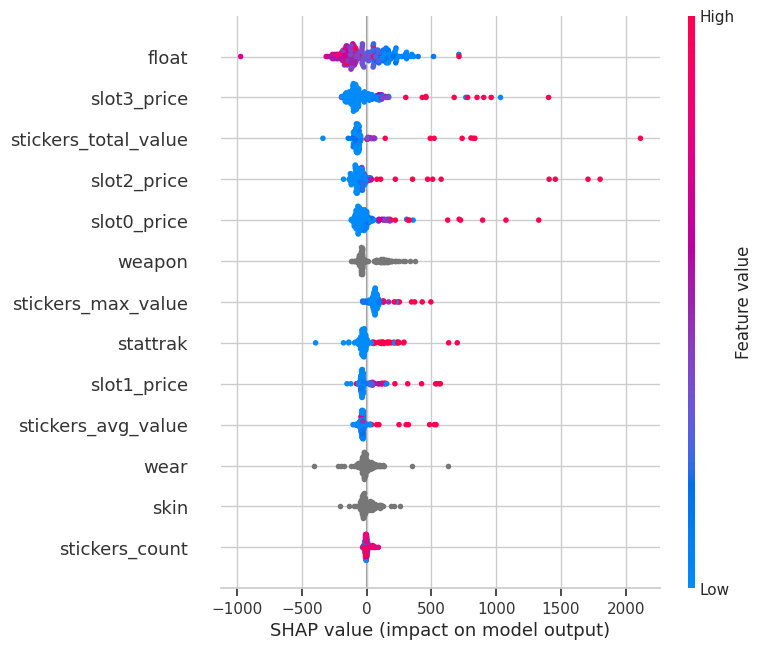

In [25]:
# Learning curves
evals_result = tuned_model.get_evals_result()
train_rmse = evals_result["learn"]["RMSE"]
val_rmse = evals_result["validation"]["RMSE"]

plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label="train RMSE")
plt.plot(val_rmse, label="val RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning curves (tuned CatBoost, weapons)")
plt.legend()
plt.show()

# Feature importance
feat_importances = tuned_model.get_feature_importance(train_pool)
importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feat_importances
}).sort_values("importance", ascending=False)

print("\n=== ТОП признаков (tuned CatBoost, weapons) ===")
display(importances_df)

plt.figure(figsize=(6, 4))
plt.barh(importances_df["feature"], importances_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature importance (tuned CatBoost, weapons)")
plt.xlabel("Importance")
plt.show()

# SHAP
explainer = shap.TreeExplainer(tuned_model)
X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

shap.summary_plot(shap_values, X_sample)
plt.show()


Learning curves показывают постепенное снижение RMSE на train и val.
Отсутствие сильного расхождения кривых говорит о том, что модель не переобучена.

График feature importance и SHAP-диаграммы показывают,
что наибольшее влияние на цену оказывают:
- тип оружия (`weapon`),
- числовые параметры, связанные с float и ценами стикеров,
- бинарный флаг `stattrak`.

Это соответствует ожиданиям доменной области и подтверждает,
что модель использует разумные закономерности, а не шум.


##Оптимизация инференса (Fast CatBoost)

In [26]:
def measure_inference_time(model, X, n_runs: int = 5) -> float:
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(X)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

time_base = measure_inference_time(baseline_model, X_test)
time_tuned = measure_inference_time(tuned_model, X_test)
time_lr = measure_inference_time(linreg_model, X_test)

print("=== Время инференса (секунд на весь X_test) ===")
print(f"CatBoost Baseline: {time_base:.4f} s")
print(f"CatBoost Tuned:    {time_tuned:.4f} s")
print(f"Linear Regression: {time_lr:.4f} s")

fast_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.1,
    iterations=400,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=50,
    verbose=False,
)

fast_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_fast = fast_model.predict(test_pool)
mae_fast = mean_absolute_error(y_test, y_pred_fast)
rmse_fast = math.sqrt(mean_squared_error(y_test, y_pred_fast))
r2_fast = r2_score(y_test, y_pred_fast)
time_fast = measure_inference_time(fast_model, X_test)

print("\n=== Fast CatBoost (weapons) ===")
print(f"MAE:  {mae_fast:.2f} $")
print(f"RMSE: {rmse_fast:.2f} $")
print(f"R²:   {r2_fast:.4f}")
print(f"Inference time: {time_fast:.4f} s")

speed_results = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base, "time_s": time_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned, "time_s": time_tuned},
    {"model": "CatBoost Fast",     "MAE": mae_fast, "RMSE": rmse_fast, "R2": r2_fast, "time_s": time_fast},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr, "time_s": time_lr},
])

print("\n=== Качество vs скорость (weapons) ===")
display(speed_results)


=== Время инференса (секунд на весь X_test) ===
CatBoost Baseline: 0.0033 s
CatBoost Tuned:    0.0033 s
Linear Regression: 0.0049 s

=== Fast CatBoost (weapons) ===
MAE:  210.47 $
RMSE: 1072.68 $
R²:   0.3238
Inference time: 0.0029 s

=== Качество vs скорость (weapons) ===


,model,MAE,RMSE,R2,time_s
0,CatBoost Baseline,192.942105,739.911698,0.678288,0.003340
1,CatBoost Tuned,197.936355,789.787285,0.633455,0.003338
2,CatBoost Fast,210.471593,1072.684033,0.323838,0.002910
3,Linear Regression,301.633192,1178.018660,0.184523,0.004893


#W&B-логирование для этого датасета

In [27]:


wandb.login()

def train_and_log_catboost_weapons(run_name: str, params: dict, log_shap: bool = False):
    with wandb.init(
        project="cs2-weapons-pricing",
        name=run_name,
        config=params
    ):
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

        # финальные метрики
        y_pred = model.predict(test_pool)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

        # learning curves
        evals_result = model.get_evals_result()
        train_rmse = evals_result["learn"]["RMSE"]
        val_rmse = evals_result["validation"]["RMSE"]

        for step, (tr, va) in enumerate(zip(train_rmse, val_rmse), start=1):
            wandb.log({"RMSE/train": tr, "RMSE/val": va}, step=step)

        # feature importance
        feat_importances = model.get_feature_importance(train_pool)
        importances_df = pd.DataFrame({
            "feature": X.columns,
            "importance": feat_importances
        }).sort_values("importance", ascending=False)

        plt.figure(figsize=(6, 4))
        plt.barh(importances_df["feature"], importances_df["importance"])
        plt.gca().invert_yaxis()
        plt.title(f"Feature Importance ({run_name})")
        plt.xlabel("Importance")
        wandb.log({"Feature Importance": wandb.Image(plt)})
        plt.close()

        # SHAP только для tuned-модели
        if log_shap:
            X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)

            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
            wandb.log({f"SHAP Summary (bar) [{run_name}]": wandb.Image(plt)})
            plt.close()

            shap.summary_plot(shap_values, X_sample, show=False)
            wandb.log({f"SHAP Summary [{run_name}]": wandb.Image(plt)})
            plt.close()

        return model


def train_and_log_linreg_weapons(run_name: str):
    numeric_features = NUM_FEATURES
    categorical_features = CAT_FEATURES

    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression())
    ])

    with wandb.init(
        project="cs2-weapons-pricing",
        name=run_name,
        config={
            "model_type": "LinearRegression",
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
        }
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

    return model


# Запуск W&B-экспериментов
baseline_params = {
    "depth": 8,
    "learning_rate": 0.05,
    "iterations": 1500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 120,
    "verbose": False,
}

tuned_params = best_params.copy()
tuned_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

cb_base_wb  = train_and_log_catboost_weapons("weapons_catboost_baseline", baseline_params, log_shap=False)
cb_tuned_wb = train_and_log_catboost_weapons("weapons_catboost_tuned", tuned_params, log_shap=True)
lr_wb       = train_and_log_linreg_weapons("weapons_linear_regression")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 20220481 (20220481-https-en-ehuniversity-lt-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


MAE,▁
R2,▁
RMSE,▁
RMSE/train,██▇▇▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
RMSE/val,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,192.9421
R2,0.67829
RMSE,739.9117
RMSE/train,1250.79435
RMSE/val,396.66975


MAE,▁
R2,▁
RMSE,▁
RMSE/train,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
RMSE/val,█▅▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
MAE,197.93636
R2,0.63345
RMSE,789.78728
RMSE/train,860.30766
RMSE/val,431.81596


MAE,▁
R2,▁
RMSE,▁
MAE,301.63319
R2,0.18452
RMSE,1178.01866
